## 1. Importação de Bibliotecas e Configurações

In [3]:
# Importações essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from scipy import stats

warnings.filterwarnings('ignore')


# Configurações de visualização
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


## 2.1 Carregamento e Split do Dataset Original
Célula usada somente uma vez para a criação da feature PATIENT_ID nos datasets de treino e teste. 

O output dos dataset com a criação dela foi guardado.

In [ ]:
# Carregar dataset original sem patient_id
print("\nDataset original com ordem de linha:")
df_full = pd.read_csv('dataset_sepsis.csv', na_values=['?'])
print(f"   Shape: {df_full.shape}")
print(f"   Total de registros: {len(df_full):,}")

# Fazer split com mesmo random_state e test_size para verificação
print("\nFazendo split do dataset original (random_state=42, test_size=0.2)...")

# Separar features e target
X_original = df_full.drop('SepsisLabel', axis=1)
y_original = df_full['SepsisLabel']

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_original, y_original, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_original
)

print(f"   Train split: {len(X_train_split):,} registros")
print(f"   Test split:  {len(X_test_split):,} registros")

# Carregar datasets atuais
df_train_atual = pd.read_csv('dataset_sepsis_train.csv', na_values=['?'])
df_test_atual = pd.read_csv('dataset_sepsis_test.csv', na_values=['?'])

print(f"Train atual: {df_train_atual.shape}] \n Test atual: {df_test_atual.shape}")

## 2. Carregamento dos Dados Para Tratamento

In [4]:

# Carregar datasets
print("\nCarregando datasets:")
df = pd.read_csv('dataset_sepsis_train.csv')

print(f"   Train atual: {df.shape}")

print("\n Todos os datasets carregados!")


Carregando datasets:
   Train atual: (1241768, 43)

 Todos os datasets carregados!
   Train atual: (1241768, 43)

 Todos os datasets carregados!


In [5]:
# Análise dos valores missing do dataset original
print("ANÁLISE DE VALORES FALTANTES (Dataset Original):")
print("=" * 50)

missing_stats = pd.DataFrame({
    'Coluna': df_train_atual.columns,
    'Missing_Count': df_train_atual.isnull().sum(),
    'Missing_Percent': (df_train_atual.isnull().sum() / len(df_train_atual)) * 100
})

missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)
print(missing_stats.to_string(index=False))


ANÁLISE DE VALORES FALTANTES (Dataset Original):


NameError: name 'df_train_atual' is not defined

## 3. Atribuição e Verificação de Patient_ID ao Dataset para Tratamento
Durante os testes no tratamento, essa atribuição e verificação foi feita somente uma vez tanto para o treino como para o teste. 

Não é necessário rodar mais de uma vez, pois o resultado é armazenado num csv. 

Após isso o csv com a coluna PATIENT_ID pode ser carregado diretamente

In [ ]:
# Criar identificador único de paciente baseado em Hour + Age
print("👤 CRIANDO IDENTIFICADOR DE PACIENTE (LÓGICA: Hour=0 + Age muda)")
print("=" * 70)

# Verificar se temos Hour e Age
if 'Hour' in df_full.columns and 'Age' in df_full.columns and 'PATIENT_ID' not in df_full.columns:
    # Lógica: quando Hour volta a 0 E Age muda, é outro paciente
    patient_id = 0
    patient_ids = []
    previous_age = None
    
    for idx, row in df_full.iterrows():
        current_hour = row['Hour']
        current_age = row['Age']
        
        # Se Hour é 0 E Age mudou em relação ao anterior, é novo paciente
        if current_hour == 0 and previous_age is not None and current_age != previous_age:
            patient_id += 1
        
        patient_ids.append(patient_id)
        previous_age = current_age
    
    df_full['PATIENT_ID'] = patient_ids
    
    print(f"✅ PATIENT_ID criado com sucesso!")
    print(f"👥 Total de pacientes únicos: {df_full['PATIENT_ID'].nunique():,}")
    print(f"📊 Registros por paciente (média): {len(df_full) / df_full['PATIENT_ID'].nunique():.1f}")

In [ ]:
# Verificar se o split é o mesmo e adicionar PATIENT_ID aos datasets atuais
print("VERIFICAÇÃO E ATRIBUIÇÃO DE PATIENT_ID")
print("=" * 70)

# Reconstruir os datasets do split (com Patient_ID)
train_split_with_id = pd.concat([X_train_split, y_train_split], axis=1)
test_split_with_id = pd.concat([X_test_split, y_test_split], axis=1)

# Função para verificar e atribuir Patient_ID (versão vetorizada otimizada)
def verify_and_assign_patient_id(split_df, atual_df, dataset_name):
    """
    Compara vetorialmente o dataset do split com o atual usando pandas.
    """
    print(f"\n🔄 Processando {dataset_name}...")
    
    # Colunas para comparação (todas exceto PATIENT_ID)
    compare_cols = [col for col in split_df.columns if col != 'PATIENT_ID']
    
    # Resetar índices para garantir comparação linha a linha
    split_df_reset = split_df.reset_index(drop=True)
    atual_df_reset = atual_df.reset_index(drop=True)
    
    # Verificar se número de linhas é igual
    if len(split_df_reset) != len(atual_df_reset):
        print(f"    ERRO: Número de linhas diferente!")
        return None
    
    # Comparação vetorizada usando "!" como placeholder para NaN
    match_mask = (split_df_reset[compare_cols].fillna("!") == 
                  atual_df_reset[compare_cols].fillna("!")).all(axis=1)
    
    matches = match_mask.sum()
    mismatches = (~match_mask).sum()
    
    print(f"   Matches: {matches:,} ({matches/len(split_df_reset)*100:.2f}%)")
    
    if mismatches == 0:
        atual_df_with_id = atual_df_reset.copy()
        atual_df_with_id['PATIENT_ID'] = split_df_reset['PATIENT_ID'].values
        print(f"   100% de match. PATIENT_ID atribuído!")
        return atual_df_with_id
    else:
        print(f"   {mismatches:,} diferenças encontradas. Patient_ID não atribuído.")
        return None

# Verificar e atribuir para TREINO
df_train_with_id = verify_and_assign_patient_id(train_split_with_id, df_train_atual, "TREINO")

# Verificar e atribuir para TESTE
df_test_with_id = verify_and_assign_patient_id(test_split_with_id, df_test_atual, "TESTE")

print("\n" + "=" * 70)
if df_train_with_id is not None and df_test_with_id is not None:
    print("VERIFICAÇÃO CONCLUÍDA: Os splits são IDÊNTICOS!")
    print("PATIENT_ID atribuído aos datasets de treino e teste!")
    
    # Salvar datasets com Patient_ID
    df_train_with_id.to_csv('dataset_sepsis_train_with_patient_id.csv', index=False)
    df_test_with_id.to_csv('dataset_sepsis_test_with_patient_id.csv', index=False)
    
    print(f"\n Datasets salvos:")
    print(f"   dataset_sepsis_train_patient_id.csv")
    print(f"   dataset_sepsis_test_patient_id.csv")

    # Atualizar variáveis para usar nas próximas seções
    df_train_atual = df_train_with_id
    df_test_atual = df_test_with_id

## 5. Análise da Variável Target

🎯 ANÁLISE DA VARIÁVEL TARGET (SepsisLabel)
Distribuição da Variável Target:
  Sem Sepsis (0.0): 1,219,435 (98.2%)
  Com Sepsis (1.0): 22,333 (1.8%)

⚖️  Taxa de Desbalanceamento: 54.6:1

👥 Distribuição por Paciente Único:
  Nunca teve Sepsis: 37,021 pacientes (92.7%)
  Teve Sepsis: 2,929 pacientes (7.3%)


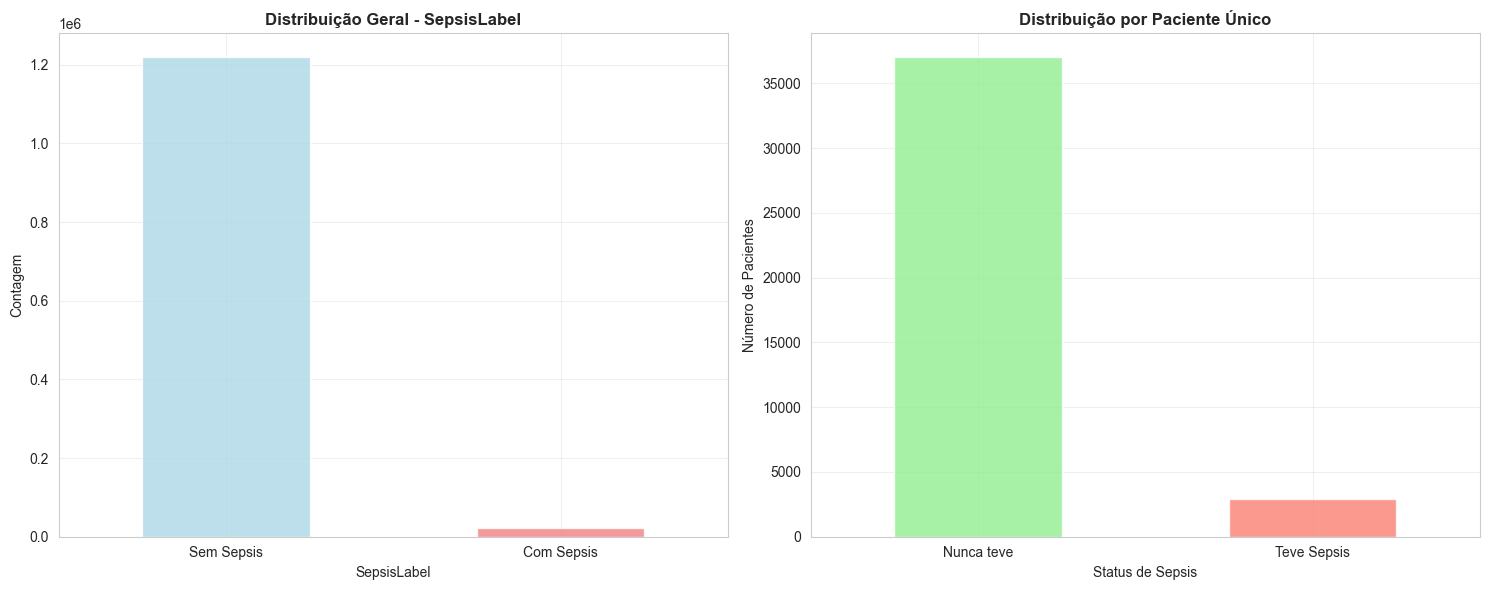

In [40]:
# Análise da variável target (SepsisLabel)
print("🎯 ANÁLISE DA VARIÁVEL TARGET (SepsisLabel)")
print("=" * 45)

if 'SepsisLabel' in df.columns:
    target_dist = df['SepsisLabel'].value_counts().sort_index()
    
    print("Distribuição da Variável Target:")
    for label, count in target_dist.items():
        percentage = (count / len(df)) * 100
        status = "Sem Sepsis" if label == 0 else "Com Sepsis"
        print(f"  {status} ({label}): {count:,} ({percentage:.1f}%)")
    
    # Calcular taxa de desbalanceamento
    imbalance_ratio = target_dist.max() / target_dist.min()
    print(f"\n⚖️  Taxa de Desbalanceamento: {imbalance_ratio:.1f}:1")
    
    # Análise por paciente único
    patient_sepsis = df.groupby('PATIENT_ID')['SepsisLabel'].max()  # Se teve sepsis em algum momento
    patient_target_dist = patient_sepsis.value_counts().sort_index()
    
    print(f"\n👥 Distribuição por Paciente Único:")
    for label, count in patient_target_dist.items():
        percentage = (count / len(patient_sepsis)) * 100
        status = "Nunca teve Sepsis" if label == 0 else "Teve Sepsis"
        print(f"  {status}: {count:,} pacientes ({percentage:.1f}%)")
    
    # Visualização
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Distribuição geral
    target_dist.plot(kind='bar', ax=axes[0], color=['lightblue', 'lightcoral'], alpha=0.8)
    axes[0].set_title('Distribuição Geral - SepsisLabel', fontweight='bold')
    axes[0].set_xlabel('SepsisLabel')
    axes[0].set_ylabel('Contagem')
    axes[0].set_xticklabels(['Sem Sepsis', 'Com Sepsis'], rotation=0)
    axes[0].grid(True, alpha=0.3)
    
    # Gráfico 2: Distribuição por paciente
    patient_target_dist.plot(kind='bar', ax=axes[1], color=['lightgreen', 'salmon'], alpha=0.8)
    axes[1].set_title('Distribuição por Paciente Único', fontweight='bold')
    axes[1].set_xlabel('Status de Sepsis')
    axes[1].set_ylabel('Número de Pacientes')
    axes[1].set_xticklabels(['Nunca teve', 'Teve Sepsis'], rotation=0)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Coluna SepsisLabel não encontrada!")

## 6. Imputação Inteligente por Paciente

In [6]:
# Identificar colunas numéricas para imputação (excluindo ID e target)
cols_to_exclude = ['PATIENT_ID', 'SepsisLabel']
cols_to_impute = [ col for col in df.columns.to_list() if col not in cols_to_exclude]

print("🔄 IMPUTAÇÃO INTELIGENTE POR PACIENTE")
print("=" * 40)
print(f"📊 Colunas numéricas para imputação: {len(cols_to_impute)}")
print(f"📋 Colunas: {cols_to_impute[:5]}...")

# Criar cópia do dataframe para imputação
df_imputed = df.copy()

# Função de imputação por paciente
def impute_patient_data(patient_data):
    """
    Aplica imputação inteligente para um paciente específico:
    1. Ordenar por Hour (essencial para imputação temporal correta)
    2. Forward fill (propagar último valor válido temporalmente)
    3. Backward fill (propagar próximo valor válido temporalmente)
    4. Média do paciente para valores ainda faltantes
    """
    patient_imputed = patient_data.copy()
    
    # CRÍTICO: Ordenar por Hour para garantir ordem temporal correta
    if 'Hour' in patient_imputed.columns:
        patient_imputed = patient_imputed.sort_values('Hour').reset_index(drop=True)
    
    for col in cols_to_impute:
        if col in patient_imputed.columns:
            # 1. Forward fill (propaga valores temporalmente para frente)
            patient_imputed[col] = patient_imputed[col].fillna(method='ffill')
            
            # 2. Backward fill (propaga valores temporalmente para trás)
            patient_imputed[col] = patient_imputed[col].fillna(method='bfill')
            
            # 3. Média do paciente (se ainda houver NaN)
            # if patient_imputed[col].isnull().any():
            #     patient_mean = patient_imputed[col].mean()
            #     if not pd.isna(patient_mean):
            #         patient_imputed[col] = patient_imputed[col].fillna(patient_mean)
    
    return patient_imputed

# Aplicar imputação por paciente
print("\n🔄 Aplicando imputação por paciente...")

imputed_patients = []
total_patients = df_imputed['PATIENT_ID'].nunique()

for i, (patient_id, patient_data) in enumerate(df_imputed.groupby('PATIENT_ID')):
    if i % 1000 == 0:  # Progress indicator
        print(f"   Processando paciente {i+1}/{total_patients} ({(i+1)/total_patients*100:.1f}%)")
    
    imputed_patient = impute_patient_data(patient_data)
    imputed_patients.append(imputed_patient)

# Combinar todos os pacientes imputados
df_imputed = pd.concat(imputed_patients, ignore_index=True)

print(f"Imputação por paciente concluída!")

🔄 IMPUTAÇÃO INTELIGENTE POR PACIENTE
📊 Colunas numéricas para imputação: 41
📋 Colunas: ['Hour', 'HR', 'O2Sat', 'Temp', 'SBP']...

🔄 Aplicando imputação por paciente...
   Processando paciente 1/39950 (0.0%)
   Processando paciente 1/39950 (0.0%)
   Processando paciente 1001/39950 (2.5%)
   Processando paciente 1001/39950 (2.5%)
   Processando paciente 2001/39950 (5.0%)
   Processando paciente 2001/39950 (5.0%)
   Processando paciente 3001/39950 (7.5%)
   Processando paciente 3001/39950 (7.5%)
   Processando paciente 4001/39950 (10.0%)
   Processando paciente 4001/39950 (10.0%)
   Processando paciente 5001/39950 (12.5%)
   Processando paciente 5001/39950 (12.5%)
   Processando paciente 6001/39950 (15.0%)
   Processando paciente 6001/39950 (15.0%)
   Processando paciente 7001/39950 (17.5%)
   Processando paciente 7001/39950 (17.5%)
   Processando paciente 8001/39950 (20.0%)
   Processando paciente 8001/39950 (20.0%)
   Processando paciente 9001/39950 (22.5%)
   Processando paciente 9001/

In [7]:
# Comparar missing values antes e depois da imputação por paciente
print("📊 COMPARAÇÃO: ANTES vs DEPOIS DA IMPUTAÇÃO POR PACIENTE")
print("=" * 60)

missing_before = df[cols_to_impute].isnull().sum()
missing_after = df_imputed[cols_to_impute].isnull().sum()

comparison = pd.DataFrame({
    'Coluna': cols_to_impute,
    'Missing_Antes': missing_before.values,
    'Missing_Depois': missing_after.values,
    'Redução': missing_before.values - missing_after.values,
    'Redução_%': ((missing_before.values - missing_after.values) / missing_before.values * 100).round(1)
})

# Mostrar apenas colunas que tinham missing values
comparison_filtered = comparison[comparison['Missing_Antes'] > 0].sort_values('Redução_%', ascending=False)

if len(comparison_filtered) > 0:
    print(comparison_filtered.to_string(index=False))
    
    total_missing_before = missing_before.sum()
    total_missing_after = missing_after.sum()
    total_reduction = ((total_missing_before - total_missing_after) / total_missing_before * 100)
    
    print(f"\n📈 RESUMO GERAL:")
    print(f"   Total missing antes: {total_missing_before:,}")
    print(f"   Total missing depois: {total_missing_after:,}")
    print(f"   Redução total: {total_reduction:.1f}%")
else:
    print("✅ Nenhum valor faltante encontrado nas colunas numéricas!")

📊 COMPARAÇÃO: ANTES vs DEPOIS DA IMPUTAÇÃO POR PACIENTE
          Coluna  Missing_Antes  Missing_Depois  Redução  Redução_%
              HR         122645             146   122499       99.9
           O2Sat         162060             398   161662       99.8
            Temp         821823            7532   814291       99.1
            Resp         190587            1915   188672       99.0
             MAP         154532            2533   151999       98.4
             SBP         180911            9142   171769       94.9
         Glucose        1029190           60250   968940       94.1
       Potassium        1125868           78000  1047868       93.1
             BUN        1156328           92614  1063714       92.0
             Hct        1131788           91930  1039858       91.9
      Creatinine        1165959           98472  1067487       91.6
             Hgb        1150009          100552  1049457       91.3
             WBC        1162155          109820  1052335    

In [8]:
missing_stats_imputation = pd.DataFrame({
    'Coluna': df_imputed.columns,
    'Missing_Count': df_imputed.isnull().sum(),
    'Missing_Percent': (df_imputed.isnull().sum() / len(df_imputed)) * 100
})

missing_stats = missing_stats_imputation[missing_stats_imputation['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)
print(missing_stats.to_string(index=False))

          Coluna  Missing_Count  Missing_Percent
Bilirubin_direct        1169611        94.189172
           EtCO2        1115619        89.841178
      Fibrinogen        1086092        87.463359
       TroponinI        1034799        83.332716
         Lactate         817435        65.828319
            SaO2         806519        64.949250
      BaseExcess         803377        64.696223
 Bilirubin_total         798385        64.294216
    Alkalinephos         797962        64.260152
             AST         793141        63.871915
            FiO2         640398        51.571469
           PaCO2         632161        50.908141
            HCO3         622322        50.115803
             PTT         617139        49.698414
              pH         613945        49.441200
        Chloride         583378        46.979629
           Unit1         485088        39.064302
           Unit2         485088        39.064302
       Phosphate         367608        29.603597
             DBP    

## 7. Imputação Global para Valores Remanescentes

In [ ]:
# Para valores que ainda estão faltando, usar imputação global
print("🌐 IMPUTAÇÃO GLOBAL PARA VALORES REMANESCENTES")
print("=" * 48)

# Verificar se ainda há valores faltantes
remaining_missing = df_imputed[numeric_cols].isnull().sum()
cols_with_missing = remaining_missing[remaining_missing > 0]

if len(cols_with_missing) > 0:
    print(f"📋 Colunas com valores ainda faltantes: {len(cols_with_missing)}")
    print(cols_with_missing.to_string())
    
    # Estratégias de imputação global
    print("\n🔄 Aplicando estratégias de imputação global...")
    
    for col in cols_with_missing.index:
        missing_count = cols_with_missing[col]
        
        # Estratégia 1: Mediana por gênero (se disponível)
        if 'Gender' in df_imputed.columns:
            gender_medians = df_imputed.groupby('Gender')[col].median()
            
            for gender in gender_medians.index:
                mask = (df_imputed['Gender'] == gender) & (df_imputed[col].isnull())
                df_imputed.loc[mask, col] = gender_medians[gender]
        
        # Estratégia 2: Mediana global para valores ainda faltantes
        global_median = df_imputed[col].median()
        df_imputed[col] = df_imputed[col].fillna(global_median)
        
        print(f"   ✅ {col}: {missing_count} valores imputados")
    
    # Verificação final
    final_missing = df_imputed[numeric_cols].isnull().sum().sum()
    print(f"\n📊 Valores faltantes após imputação global: {final_missing}")
    
else:
    print("✅ Nenhum valor faltante remanescente - imputação por paciente foi suficiente!")

## 8. Selecao de variaveis

In [21]:
# Colunas para remover, exceto HGB, Creatinine, Hct e Glucose
# Hgb
# Creatinine
# pH
# Fibrinogen
# Hct
# PTT
# Calcium
# Bilirubin_total
# Alkalinephos
# Phosphate
# Bilirubin_direct
# Lactate
# Glucose
# AST
# Potassium
# TroponinI
# EtCO2
# BaseExcess
# HCO3
# FiO2
# PaCO2
# SaO2
# Chloride
# Magnesium


df_dropped = df_imputed.copy()
columns_to_drop = ['pH', 'Fibrinogen', 'PTT', 'Calcium', 'Bilirubin_total', 'Alkalinephos', 'Phosphate', 'Bilirubin_direct', 'Lactate', 'AST', 'Chloride', 'TroponinI', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'PaCO2', 'SaO2', 'Chloride', 'Magnesium']

# Usar somente map -> dropar sbp e dbp
columns_to_drop += ['SBP', 'DBP', 'Unit1', 'Unit2']

# Dropar patient_id visto que não é feature preditiva
# columns_to_drop += ['PATIENT_ID']

print("\nREMOVENDO COLUNAS COM ALTA TAXA DE MISSING OU BAIXA IMPORTÂNCIA")
df_dropped.drop(columns=columns_to_drop, inplace=True)
print(f"Colunas removidas. Novo shape: {df_dropped.shape}")


REMOVENDO COLUNAS COM ALTA TAXA DE MISSING OU BAIXA IMPORTÂNCIA
Colunas removidas. Novo shape: (1241768, 20)


In [22]:
missing_stats_imputation = pd.DataFrame({
    'Coluna': df_dropped.columns,
    'Missing_Count': df_dropped.isnull().sum(),
    'Missing_Percent': (df_dropped.isnull().sum() / len(df_dropped)) * 100
})

missing_stats = missing_stats_imputation[missing_stats_imputation['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)
print(missing_stats.to_string(index=False))

     Coluna  Missing_Count  Missing_Percent
  Platelets         112085         9.026243
        WBC         109820         8.843842
        Hgb         100552         8.097487
 Creatinine          98472         7.929984
        BUN          92614         7.458237
        Hct          91930         7.403154
  Potassium          78000         6.281367
    Glucose          60250         4.851953
       Temp           7532         0.606555
        MAP           2533         0.203983
       Resp           1915         0.154216
      O2Sat            398         0.032051
         HR            146         0.011757
HospAdmTime              6         0.000483


In [23]:
df_clean = df_dropped.drop_duplicates()
df_clean = df_clean.dropna()

In [24]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1102127 entries, 0 to 1241767
Data columns (total 20 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Hour         1102127 non-null  int64  
 1   HR           1102127 non-null  float64
 2   O2Sat        1102127 non-null  float64
 3   Temp         1102127 non-null  float64
 4   MAP          1102127 non-null  float64
 5   Resp         1102127 non-null  float64
 6   BUN          1102127 non-null  float64
 7   Creatinine   1102127 non-null  float64
 8   Glucose      1102127 non-null  float64
 9   Potassium    1102127 non-null  float64
 10  Hct          1102127 non-null  float64
 11  Hgb          1102127 non-null  float64
 12  WBC          1102127 non-null  float64
 13  Platelets    1102127 non-null  float64
 14  Age          1102127 non-null  float64
 15  Gender       1102127 non-null  float64
 16  HospAdmTime  1102127 non-null  float64
 17  ICULOS       1102127 non-null  float64
 18  SepsisL

🎯 ANÁLISE DA VARIÁVEL TARGET (SepsisLabel)
Distribuição da Variável Target:
  Sem Sepsis (0.0): 1,083,507 (98.3%)
  Com Sepsis (1.0): 18,620 (1.7%)

⚖️  Taxa de Desbalanceamento: 58.2:1

👥 Distribuição por Paciente Único:
  Nunca teve Sepsis: 30,993 pacientes (92.8%)
  Teve Sepsis: 2,408 pacientes (7.2%)


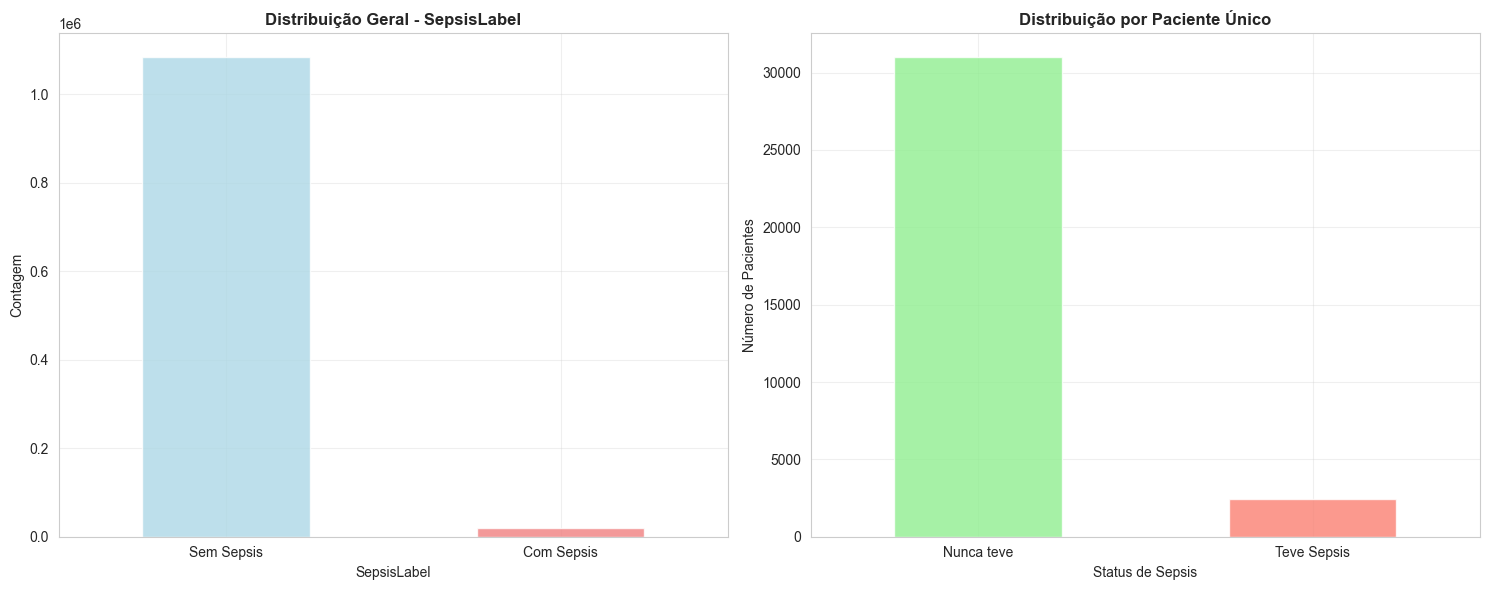

In [25]:
# Análise da variável target (SepsisLabel)
print("🎯 ANÁLISE DA VARIÁVEL TARGET (SepsisLabel)")
print("=" * 45)

if 'SepsisLabel' in df_clean.columns:
    target_dist = df_clean['SepsisLabel'].value_counts().sort_index()
    
    print("Distribuição da Variável Target:")
    for label, count in target_dist.items():
        percentage = (count / len(df_clean)) * 100
        status = "Sem Sepsis" if label == 0 else "Com Sepsis"
        print(f"  {status} ({label}): {count:,} ({percentage:.1f}%)")
    
    # Calcular taxa de desbalanceamento
    imbalance_ratio = target_dist.max() / target_dist.min()
    print(f"\n⚖️  Taxa de Desbalanceamento: {imbalance_ratio:.1f}:1")
    
    # Análise por paciente único
    patient_sepsis = df_clean.groupby('PATIENT_ID')['SepsisLabel'].max()  # Se teve sepsis em algum momento
    patient_target_dist = patient_sepsis.value_counts().sort_index()
    
    print(f"\n👥 Distribuição por Paciente Único:")
    for label, count in patient_target_dist.items():
        percentage = (count / len(patient_sepsis)) * 100
        status = "Nunca teve Sepsis" if label == 0 else "Teve Sepsis"
        print(f"  {status}: {count:,} pacientes ({percentage:.1f}%)")
    
    # Visualização
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Distribuição geral
    target_dist.plot(kind='bar', ax=axes[0], color=['lightblue', 'lightcoral'], alpha=0.8)
    axes[0].set_title('Distribuição Geral - SepsisLabel', fontweight='bold')
    axes[0].set_xlabel('SepsisLabel')
    axes[0].set_ylabel('Contagem')
    axes[0].set_xticklabels(['Sem Sepsis', 'Com Sepsis'], rotation=0)
    axes[0].grid(True, alpha=0.3)
    
    # Gráfico 2: Distribuição por paciente
    patient_target_dist.plot(kind='bar', ax=axes[1], color=['lightgreen', 'salmon'], alpha=0.8)
    axes[1].set_title('Distribuição por Paciente Único', fontweight='bold')
    axes[1].set_xlabel('Status de Sepsis')
    axes[1].set_ylabel('Número de Pacientes')
    axes[1].set_xticklabels(['Nunca teve', 'Teve Sepsis'], rotation=0)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Coluna SepsisLabel não encontrada!")

## 10. Formatacao dos Dados

In [ ]:


import scipy.stats as stats
from scipy.stats import boxcox, anderson, kstest
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings('ignore')

def validate_normality_transformations(data, column_name, sample_size=300000, 
                                     plot_results=True, alpha=0.05):
    """
    Testa múltiplas transformações (Logarítmica, Raiz Quadrada, Box-Cox, Yeo-Johnson) para aproximar dados de distribuição normal
    
    Parameters
    -----------
    data : pd.Series or np.array
        Dados originais a serem transformados
    column_name : str
        Nome da variável para relatórios
    sample_size : int
        Tamanho da amostra para testes
    plot_results : bool
        Se deve plotar as distribuições
    alpha : float
        Nível de significância para testes estatísticos
        
    Returns
    --------
    results : dict 
        Resultados detalhados de todas as transformações
    Contains
    - original: Dados originais e métricas
    - best_transformation: Nome da melhor transformação baseada nas métricas
    - transformations: Dados transformados e métricas para cada método
    Example
        - results[transformations]['log']['metrics']: Métricas para medir normalidade
        - results[transformations]['yeo-johnson']['data']: Dados transformados
        - results[transformations]['yeo-johnson']['formula']: Parâmetros da distribuição
        - results[transformations]['yeo-johnson']['lambda']: Valor lambda (yeo-johson e boxcox)
    """
    
    # Amostra para performance (mantém distribuição)
    if len(data) > sample_size:
        data_sample = data.sample(n=sample_size, random_state=42).copy()
    else:
        data_sample = data.copy()
    
    # Remover valores inválidos (precaução)
    data_clean = data_sample.dropna()
    data_clean = data_clean[np.isfinite(data_clean)]

    # Dicionário para armazenar resultados
    results = {
        'original': {'data': data_clean.copy()},
        'transformations': {}
    }
    
    if (data_clean > 0).all():
        # TRANSFORMAÇÃO 1: Logaritmo (não suporta valores <=0)
        log_data = np.log(data_clean)
        results['transformations']['log'] = {'data': log_data, 'formula': 'log(x)'}

    if (data_clean >= 0).all():
        # TRANSFORMAÇÃO 2: Square Root (não suporta valores <0)  
        sqrt_data = np.sqrt(data_clean)
        results['transformations']['sqrt'] = {'data': sqrt_data, 'formula': 'sqrt(x)'}

    if (data_clean > 0).all():
        # TRANSFORMAÇÃO 3: Box-Cox (não suporta valores <=0)
        boxcox_data, lambda_bc = boxcox(data_clean)
        results['transformations']['boxcox'] = {
            'data': boxcox_data, 
            'formula': f'boxcox(x, λ={lambda_bc:.3f})',
            'lambda': lambda_bc
        }

    # TRANSFORMAÇÃO 4: Yeo-Johnson (aceita todo valor Real)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    yj_data = pt.fit_transform(data_clean.values.reshape(-1, 1)).flatten()
    results['transformations']['yeo_johnson'] = {
        'data': yj_data,
        'formula': f'yeo-johnson(x, λ={pt.lambdas_[0]:.3f})',
        'lambda': pt.lambdas_[0]
    }
    
    # Calcular métricas para dados originais
    results['original']['metrics'] = calculate_normality_metrics(data_clean, 'Original', alpha=alpha)
    
    # Calcular métricas para todas as transformações
    for transf_name, transf_data in results['transformations'].items():
        transf_data['metrics'] = calculate_normality_metrics(
            transf_data['data'], transf_name.title(), alpha=alpha
        )
    
    # Encontrar melhor transformação
    all_metrics = [results['original']['metrics']]
    all_metrics.extend([t['metrics'] for t in results['transformations'].values()])
    
    best_transformation = max(all_metrics, key=lambda x: x['normality_score'])
    results['best_transformation'] = best_transformation['name']

    print(f"\nMELHOR TRANSFORMAÇÃO: {best_transformation['name'].upper()}")
    
    # Plot das distribuições (se solicitado)
    if plot_results:
        plot_transformations(results, column_name)
    
    return results

# Função para calcular métricas de normalidade
def calculate_normality_metrics(data_vals, name, alpha=0.05):
    metrics = {'name': name}
    
    # Anderson-Darling
    anderson_result = anderson(data_vals, dist='norm')
    # Critical value para alpha=0.05 (índice 2)
    critical_value = anderson_result.critical_values[2]  
    metrics['anderson_stat'] = anderson_result.statistic
    metrics['anderson_critical'] = critical_value
    metrics['anderson_normal'] = anderson_result.statistic < critical_value
    
    # Kolmogorov-Smirnov
    normalized_data = (data_vals - np.mean(data_vals)) / np.std(data_vals)
    ks_stat, ks_p = kstest(normalized_data, 'norm')
    metrics['ks_stat'] = ks_stat
    metrics['ks_pvalue'] = ks_p
    metrics['ks_normal'] = ks_p > alpha
    
    # Skewness e Kurtosis
    metrics['skewness'] = stats.skew(data_vals)
    metrics['kurtosis'] = stats.kurtosis(data_vals)
    metrics['skew_normal'] = abs(metrics['skewness']) < 1.0  # Critério: |skew| < 1
    metrics['kurt_normal'] = abs(metrics['kurtosis']) < 3.0  # Critério: |kurt| < 3
    
    # Score combinado de normalidade (0-4, maior = mais normal)
    criteria = [
        metrics.get('anderson_normal', False), 
        metrics.get('ks_normal', False),
        metrics.get('skew_normal', False),
        metrics.get('kurt_normal', False)
    ]
    score = sum(criteria)
    metrics['normality_score'] = score
    metrics['criteria_met'] = criteria
    
    return metrics


def plot_transformations(results, column_name):
    """Plota histogramas e Q-Q plots das transformações"""
    
    # Contar transformações disponíveis
    n_transforms = 1 + len(results['transformations'])  # +1 para original
    
    # Configurar subplots
    fig, axes = plt.subplots(2, min(4, n_transforms), figsize=(16, 8))
    if n_transforms == 1:
        axes = axes.reshape(2, 1)
    elif n_transforms > 4:
        # Se mais de 4, mostrar apenas os 4 melhores
        all_metrics = [results['original']['metrics']]
        all_metrics.extend([t['metrics'] for t in results['transformations'].values()])
        best_4 = sorted(all_metrics, key=lambda x: x['normality_score'], reverse=True)[:4]
        n_transforms = 4
    
    fig.suptitle(f'Transformações de Normalidade - {column_name}', fontsize=14, fontweight='bold')
    
    plot_idx = 0
    
    # Plot dados originais
    data_orig = results['original']['data']
    metrics_orig = results['original']['metrics']
    
    # Histogram
    axes[0, plot_idx].hist(data_orig, bins=50, alpha=0.7, color='blue', density=True)
    axes[0, plot_idx].set_title(f"Original (Score: {metrics_orig['normality_score']})")
    axes[0, plot_idx].set_ylabel('Density')
    
    # Q-Q plot
    stats.probplot(data_orig, dist="norm", plot=axes[1, plot_idx])
    axes[1, plot_idx].set_title('Q-Q Plot Original')
    
    plot_idx += 1
    
    # Plot transformações (limitado a 3 para caber na figura)
    transform_items = list(results['transformations'].items())
    if len(transform_items) > 3:
        # Pegar as 3 melhores transformações
        transform_metrics = [(name, data['metrics']) for name, data in transform_items]
        best_3_transforms = sorted(transform_metrics, 
                                 key=lambda x: x[1]['normality_score'], 
                                 reverse=True)[:3]
        transform_names = [name for name, _ in best_3_transforms]
    else:
        transform_names = list(results['transformations'].keys())
    
    for transf_name in transform_names:
        if plot_idx >= min(4, n_transforms):
            break

        transf_data = results['transformations'][transf_name]['data']
        metrics = results['transformations'][transf_name]['metrics']

        # Histogram
        axes[0, plot_idx].hist(transf_data, bins=50, alpha=0.7, density=True)
        axes[0, plot_idx].set_title(f"{transf_name.title()} (Score: {metrics['normality_score']})")

        # Q-Q plot
        stats.probplot(transf_data, dist="norm", plot=axes[1, plot_idx])
        axes[1, plot_idx].set_title(f'Q-Q Plot {transf_name.title()}')

        plot_idx += 1
    
    # Esconder axes não utilizados
    for idx in range(plot_idx, axes.shape[1]):
        axes[0, idx].set_visible(False)
        axes[1, idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()




In [ ]:

# Selecionar variáveis numéricas para análise de normalidade
numeric_columns = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()

# Dicionário para armazenar resultados de todas as variáveis
all_normality_results = {}
transformation_summary = []

for col in numeric_columns:
    print(f"\nAnalisando: {col}")
    
    # Verificar se há dados suficientes
    valid_data = X_train_fe[col].dropna()
    if len(valid_data) > 1000:
        results = validate_normality_transformations(
            data=valid_data,
            column_name=col, 
            sample_size=len(valid_data), 
            plot_results=False  # Sem plots para análise rápida
        )
        
        if results:
            all_normality_results[col] = results
            
            # Resumir resultado
            best_transform = results['best_transformation']
            original_score = results['original']['metrics']['normality_score']
            
            if best_transform != 'Original':
                best_score = results['transformations'][best_transform.lower()]['metrics']['normality_score']
                improvement = best_score - original_score
                formula = results['transformations'][best_transform.lower()]['formula']
            else:
                best_score = original_score
                improvement = 0
                formula = "Sem transformação"
            
            transformation_summary.append({
                'variable': col,
                'original_score': original_score,
                'best_transformation': best_transform, 
                'best_score': best_score,
                'improvement': improvement,
                'formula': formula
            })

# Relatório consolidado

# Ordenar por maior melhoria
transformation_summary.sort(key=lambda x: x['improvement'], reverse=True)

print(f"{'Variável':<15} {'Score_Orig':<11} {'Melhor Transform':<15} {'Score_Final':<12} {'Melhoria':<9} {'Recomendação'}")
print("-" * 90)

recommendations = []

for item in transformation_summary:
    var = item['variable'][:14]
    orig_score = item['original_score']
    best_transf = item['best_transformation'][:14]
    best_score = item['best_score']
    improvement = item['improvement']
    formula = item['formula'][:30]
    
    # Determinar recomendação
    if improvement >= 2:
        recommendation = "🟢 APLICAR"
        recommendations.append((item['variable'], best_transf, formula))
    elif improvement >= 1:
        recommendation = "🟡 CONSIDERAR"
    else:
        recommendation = "🔴 MANTER ORIGINAL"
    
    print(f"{var:<15} {orig_score:<11} {best_transf:<15} {best_score:<12} {improvement:+.1f}{'':<6} {recommendation}")

if recommendations:
    print(f"\nIMPLEMENTAR ESTAS TRANSFORMAÇÕES:")
    for var, transform, formula in recommendations:
        print(f"   • {var}: {transform} → {formula}")

In [ ]:
# Troque o nome da variável abaixo e execute a célula para ver os Plots

column_name = 'O2Sat'  # Exemplo: 'O2Sat', 'BUN', 'WBC', 'Hour', etc.
hour_results = validate_normality_transformations(
    data=X_train_fe[column_name], 
    column_name=column_name,
    sample_size=len(X_train_fe),  # Usar todos os dados
    plot_results=True
)

## 11. Divisão dos Dados

In [ ]:
# Divisão estratificada dos dados
print("🔀 DIVISÃO DOS DADOS")
print("=" * 20)

# Preparar features e target
if 'SepsisLabel' in df_scaled.columns:
    # Remover colunas não-features
    feature_columns = [col for col in df_scaled.columns 
                      if col not in ['SepsisLabel', 'PATIENT_ID', 'Age_Rounded']]
    
    X = df_scaled[feature_columns]
    y = df_scaled['SepsisLabel']
    
    print(f"📊 Shape das features (X): {X.shape}")
    print(f"🎯 Shape do target (y): {y.shape}")
    
    # Divisão estratificada
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        stratify=y, 
        random_state=42
    )
    
    print(f"\n📈 Divisão realizada:")
    print(f"   Treino: {X_train.shape[0]:,} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"   Teste:  {X_test.shape[0]:,} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # Verificar balanceamento
    train_dist = y_train.value_counts(normalize=True).sort_index()
    test_dist = y_test.value_counts(normalize=True).sort_index()
    
    print(f"\n⚖️  Distribuição do target:")
    print(f"   Treino - Sem Sepsis: {train_dist[0]:.1%}, Com Sepsis: {train_dist[1]:.1%}")
    print(f"   Teste  - Sem Sepsis: {test_dist[0]:.1%}, Com Sepsis: {test_dist[1]:.1%}")
    
else:
    print("❌ Coluna SepsisLabel não encontrada para divisão!")

## 12. Salvamento dos Dados Processados

In [ ]:
# Salvar datasets processados
print("💾 SALVAMENTO DOS DADOS PROCESSADOS")
print("=" * 38)

# Salvar dataset completo processado
output_file = 'dataset_sepsis_prepared_v2.csv'
df_scaled.to_csv(output_file, index=False)
print(f"✅ Dataset completo salvo: {output_file}")
print(f"   Shape: {df_scaled.shape}")

if 'SepsisLabel' in df_scaled.columns:
    # Salvar conjuntos de treino e teste
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    
    train_file = 'sepsis_train_prep_v2.csv'
    test_file = 'sepsis_test_prep_v2.csv'
    
    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)
    
    print(f"✅ Dataset de treino salvo: {train_file}")
    print(f"   Shape: {train_data.shape}")
    print(f"✅ Dataset de teste salvo: {test_file}")
    print(f"   Shape: {test_data.shape}")
    
    # Salvar informações sobre as features
    feature_info = pd.DataFrame({
        'Feature': feature_columns,
        'Type': [str(X[col].dtype) for col in feature_columns],
        'Missing_Original': [df[col].isnull().sum() if col in df.columns else 0 for col in feature_columns],
        'Missing_Final': [df_scaled[col].isnull().sum() for col in feature_columns]
    })
    
    feature_info.to_csv('features_info_v2.csv', index=False)
    print(f"✅ Informações das features salvas: features_info_v2.csv")

print(f"\nPROCESSAMENTO CONCLUÍDO COM SUCESSO!")
print(f"Total de features: {len(feature_columns) if 'feature_columns' in locals() else 'N/A'}")
print(f"Total de registros processados: {len(df_scaled):,}")